# PANDAPROSUMER EXAMPLE: HEAT PUMP AND 2 DEMANDS

## DESCRIPTION:
This example demonstrates how to create a single heat pump element in pandaprosumer, which is connected to both a heat consumer (heat demand) and a dry cooler. When the heat pump produces more heat than the consumer requires, the excess is supplied to the dry cooler.

The heat demand and source temperature data are read from an Excel file and stored in a pandas DataFrame. This data includes the consumer’s required power and the source temperature at each time step.


![title](img/hp_hd_dc.png)

## Glossary:
- Network: A configuration of connected energy generators and energy consumers
- Element: A single energy generator or a single energy consumer
- Controller: The logic of an element that defines its behaviour and its limits
- Prosumer/Container: A pandaprosumer data structure that holds data related to elements and their controllers.
- Const Profile Controller: The initial controller in the network that interacts with other element controllers; it also manages external data via time series.
- Map / mapping: A connection between two controllers that specifies what information is exchanged between the corresponding elements.

## Network design philosophy:
In pandaprosumer, a system's component is represented by a network element. Each element is assigned a container and its own element controller. A container is a structure that contains the component's configuration data (static input data), which can include information that will not change in the analysis such as size, nominal power, efficiency, etc. The behaviour of an element is governed by its controller. Connections between elements are defined in maps, which couple output parameters of one controller to the input parameter of a controller of a connected element. The network is managed by a controller called ConstProfileController. This controller is connected to all element controllers and manages dynamic input data from external sources (e.g. Excel file). For each time step it distributes the dynamic input data to the relevant element controllers.

# 1 - INPUT DATA:
First let's import libraries required for data management.

In [90]:
import pandas as pd
from pandapower.timeseries.data_sources.frame_data import DFData

Next we need to define properties of the heat pump (hp) which are treated as static input data, i.e. data (characteristics) that don't change during an analysis. In this case the properties for the heat pump are :


- `carnot_efficiency`: The efficiency of the heat pump relative to the Carnot cycle (dimensionless, between 0 and 1).
- `pinch_c`: The pinch point temperature difference (°C), which represents the minimum temperature difference in the heat exchanger.
- `delta_t_evap_c`: The temperature difference at the evaporator (°C).
- `max_p_comp_kw`: The maximum compressor power (kW), which limits the heat pump's capacity.
- `name`: A label identifying the heat pump.

Next, we define the properties of the **dry cooler (dc)** :

- `n_nom_rpm`:   Nominal rotational speed of the fans [rpm]
- `p_fan_nom_kw`: Nominal electric power of each fan [kW]
- `qair_nom_m3_per_h`: Nominal air flow [m3/h]
- `t_air_in_nom_c`: Air nominal input temperature [C]
- `t_air_out_nom_c`:Air nominal output temperature [C]
- `t_fluid_in_nom_c `:Air nominal input temperature [C]
- `t_fluid_out_nom_c `:Air nominal output temperature [C]
- `fans_number `:Number of fans in the dry cooler
- `adiabatic_mode `:Whether to use the air adiabatic pre-cooling mode.
- `min_delta_t_air_c`:Minimum air temperature difference [C]

 While these arguments are generally optional, in our specific case they are required in order to fully configure the heat exchanger. Other optional arguments are also available for more advanced configurations.

In [91]:
hp_params = {"carnot_efficiency": 0.5,
             "pinch_c": 0,
             "delta_t_evap_c": 5,
             "max_p_comp_kw": 200,
             "name":'air_water_heat_pump'}

dc_params = {'fans_number': 8,
             'n_nom_rpm': 300,
             'p_fan_nom_kw': 15,
             'qair_nom_m3_per_h': 50000,
             't_air_in_nom_c': 25,
             't_air_out_nom_c': 45,
             't_fluid_in_nom_c': 76,
             't_fluid_out_nom_c': 30,
             'adiabatic_mode': True,
             'min_delta_t_air_c': 5,
             'name': 'dry cooler'}


hd_params = {"name": 'heat_consumer'}

We define the analysis time series.

In [92]:
start = '2020-01-01 00:00:00'
end = '2020-01-01 23:59:59'
time_resolution_s = 900

Now we import our demand data and transform it into an appropriate DFData object. All data of an individual element is stored in a dedicated DFData object.

In [93]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

demand_data = pd.read_excel('data/hp_dc_data.xlsx')

dur = pd.date_range(start=start, end=end, freq='900s',tz='utc')
demand_data.index = dur
demand_input = DFData(demand_data)
demand_input.df.head(10)


,t_air,demand_power,t_feed_demand_c,t_return_demand_c,mdot_fluid_kg_per_s,phi_air_in_percent
2020-01-01 00:00:00+00:00,25,0,80,20,1,30
2020-01-01 00:15:00+00:00,25,0,80,20,1,30
2020-01-01 00:30:00+00:00,25,0,80,20,1,30
2020-01-01 00:45:00+00:00,25,0,80,20,1,30
2020-01-01 01:00:00+00:00,25,0,80,20,1,30
2020-01-01 01:15:00+00:00,25,500,80,20,1,30
2020-01-01 01:30:00+00:00,25,500,80,20,1,30
2020-01-01 01:45:00+00:00,25,500,80,20,1,30
2020-01-01 02:00:00+00:00,25,321,80,20,1,30
2020-01-01 02:15:00+00:00,25,321,80,20,1,30


We can plot the evolution of the demand from the Excel file.

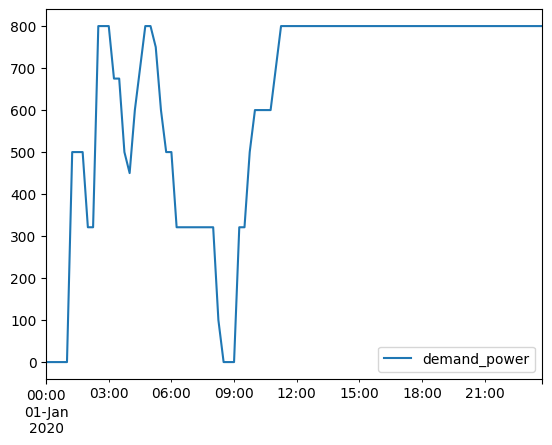

In [94]:
import matplotlib.pyplot as plt

demand_input.df.plot(y='demand_power')
plt.show()

# 2 - CREATING ELEMENTS OF THE NETWORK:
In this example, the network is made up of three elements: a source, two consumer. The source is represented by a single heat pump, the first consumer is modelled by a single heat demand element and the second one in modelled by a single dry cooler element.

We begin by defining an empty prosumer container object and then add the different elements and their respective controllers to it.

In [95]:
from pandaprosumer.create import create_empty_prosumer_container

prosumer = create_empty_prosumer_container()

Then we define the period of the analysis using input data about the analysis of time and also timezone and period name.

In [96]:
from pandaprosumer.create import create_period

period_id = create_period(prosumer, time_resolution_s, start, end, 'utc', 'default')

Now we can create the controllers connected to their respective containers and data. We also define the topology of the network by setting the elements' priority. In this example, the network has a linear configuration (the direction of energy flow goes in one direction), so only the order parameter is set:

- The const profile controller is always the first element in the network and is the only one that reads data from external sources (order 0, level 0),
- As the source, the gas boiler controller is the second element (order 0, level 1) in the network,
- Third element represents the heat exchanger(order 1, level 1),
 -The final order is the demand (order 2, level 1).

We begin by creating the Const Profile Controller.

In [97]:
from pandaprosumer.create_controlled import create_controlled_const_profile

cp_input_columns = ["t_air", "demand_power", "t_feed_demand_c", "t_return_demand_c","mdot_fluid_kg_per_s","phi_air_in_percent"]
cp_result_columns = ["t_evap_in_c", "qdemand_kw", "t_feed_demand_c", "t_return_demand_c","mdot_fluid_kg_per_s","phi_air_in_percent"]
cp_controller_index = create_controlled_const_profile(prosumer, cp_input_columns, cp_result_columns, period_id, demand_input, 0, 0)

The heat exchanger, Gas Boiler and Heat demand controllers are now created

In [98]:
from pandaprosumer.create_controlled import create_controlled_heat_pump,create_controlled_dry_cooler,create_controlled_heat_demand

hp_controller_index = create_controlled_heat_pump(prosumer, period=period_id, level=1, order=0, **hp_params)
hd_controller_index = create_controlled_heat_demand(prosumer, period=period_id, level=1, order=1,**hd_params)
dc_controller_index = create_controlled_dry_cooler(prosumer, period=period_id, level=1, order=2, **dc_params)

Unable to find Lower Heating Value for air
Unable to find Higher Heating Value for air


We can check that the elements were connected added to the prosumer with the specified parameters

In [99]:
prosumer.heat_pump

,name,delta_t_evap_c,carnot_efficiency,pinch_c,delta_t_hot_default_c,max_p_comp_kw,min_p_comp_kw,max_t_cond_out_c,max_cop,cond_fluid,evap_fluid,in_service
0,air_water_heat_pump,5.0,0.5,0.0,5.0,200.0,NaN,NaN,NaN,water,water,True


In [100]:
prosumer.dry_cooler

,name,n_nom_rpm,p_fan_nom_kw,qair_nom_m3_per_h,t_air_in_nom_c,t_air_out_nom_c,t_fluid_in_nom_c,t_fluid_out_nom_c,fans_number,adiabatic_mode,phi_adiabatic_sat_percent,min_delta_t_air_c,in_service
0,dry cooler,300.0,15.0,50000.0,25.0,45.0,76.0,30.0,8,True,99.0,5.0,True


In [101]:
prosumer.heat_demand

,name,scaling,in_service
0,heat_consumer,1.0,True


Additionnaly, we can check that for each element, a controller has been added to the prosumer

In [102]:
prosumer.controller

,object,in_service,order,level,initial_run,recycle
0,ConstProfileController,True,0,0,True,False
1,HeatPumpController,True,0,1,True,False
2,HeatDemandController,True,1,1,True,False
3,DryCoolerController,True,2,1,True,False


# 4 - CREATING CONNECTIONS (MAPS) BETWEEN THE CONTROLLERS:
network configuration

For each controller we define how it is connected to other controllers.

In [103]:
from pandaprosumer.mapping import GenericMapping
from pandaprosumer.mapping import FluidMixMapping

In [104]:
GenericMapping(prosumer,
               initiator_id=cp_controller_index,
               initiator_column="t_evap_in_c",
               responder_id=hp_controller_index,
               responder_column="t_evap_in_c",
               order=0)

CONNECTION CONST PROFILE CONTROLLER ---> HEAT DEMAND:

The connection from the Const Profile Controller to the Heat Demand Controller enables the heat demand to access the demand_power, t_feed_demand_c, t_return_demand_c columns from the input time series dataset.

The order=1 in this mapping between ConstProfileController and HeatDemandController defines the sequence in which this mapping is applied, relative to other mappings from the ConstProfileController. It ensures that this mapping happens in the correct order if there are multiple mappings from the same initiator controller.

This mapping order is separate from the controller execution order, which defines when the controllers themselves are executed during each simulation step. The order=1 ensures the data flows in the intended sequence without affecting the overall controller run order.

In [105]:
GenericMapping(prosumer,
               initiator_id=cp_controller_index,
               initiator_column=["qdemand_kw", "t_feed_demand_c", "t_return_demand_c"],
               responder_id=hd_controller_index,
               responder_column=["q_demand_kw", "t_feed_demand_c", "t_return_demand_c"],
               order=1)

CONNECTION CONST PROFILE CONTROLLER ---> Dry Cooler:

The connection from the Const Profile Controller to the Dry Cooler Controller enables the dry cooler to access the t_feed_demand_c, t_return_demand_c, t_evap_in_c,mdot_fluid_kg_per_s,  phi_air_in_percent columns from the input time series dataset.


In [106]:
GenericMapping(prosumer,
               initiator_id=cp_controller_index,
               initiator_column=["t_feed_demand_c", "t_return_demand_c", "mdot_fluid_kg_per_s", "t_evap_in_c", "phi_air_in_percent"],
               responder_id=dc_controller_index,
               responder_column=["t_in_c", "t_out_c", "mdot_fluid_kg_per_s", "t_air_in_c", "phi_air_in_percent"],
               order=2)


CONNECTION HEAT PUMP --->HEAT DEMAND:
The connection between the Heat Pump Controller and the Heat Demand Controller allows the Heat Demand to read the pump’s output and use it as an input for its own calculations. Instead of a generic mapping, a fluid mix mapping is used—this is necessary because the parameters being exchanged, such as mass flow, are dynamic and not static.

In [107]:
FluidMixMapping(prosumer,
                initiator_id=hp_controller_index,
                responder_id=hd_controller_index,
                order=0)

CONNECTION HEAT PUMP --->DRY COOLER:
The connection between the Heat Pump Controller and the Dry Cooler Controller allows the dry cooler to read the pump’s output and use it as an input for its own calculations. Instead of a generic mapping, a fluid mix mapping is used—this is necessary because the parameters being exchanged, such as mass flow, are dynamic and not static. Order = 1 because the initiator is already mapped to a responder and we need to define an order.

In [108]:
FluidMixMapping(prosumer,
                initiator_id=hp_controller_index,
                responder_id=dc_controller_index,
                order=1)

5 - RUNNING THE ANALYSIS:
We can now run the analysis with the input data defined above.

In [109]:
from pandaprosumer.run_time_series import run_timeseries

run_timeseries(prosumer, period_id, verbose=True)

  0%|          | 0/96 [00:00<?, ?it/s]/mnt/c/Users/mena138/Projects/SenergyNets/pandaprosumer/pandaprosumer/controller/models/dry_cooler.py:270: RuntimeWarning: divide by zero encountered in scalar divide
  a_cold = delta_t_cold_c / (q_ratio * lmtd_nom)
/mnt/c/Users/mena138/Projects/SenergyNets/pandaprosumer/pandaprosumer/controller/models/dry_cooler.py:270: RuntimeWarning: divide by zero encountered in scalar divide
  a_cold = delta_t_cold_c / (q_ratio * lmtd_nom)
/mnt/c/Users/mena138/Projects/SenergyNets/pandaprosumer/pandaprosumer/controller/models/dry_cooler.py:270: RuntimeWarning: divide by zero encountered in scalar divide
  a_cold = delta_t_cold_c / (q_ratio * lmtd_nom)
/mnt/c/Users/mena138/Projects/SenergyNets/pandaprosumer/pandaprosumer/controller/models/dry_cooler.py:270: RuntimeWarning: divide by zero encountered in scalar divide
  a_cold = delta_t_cold_c / (q_ratio * lmtd_nom)
 16%|█▌        | 15/96 [00:00<00:00, 140.62it/s]/mnt/c/Users/mena138/Projects/SenergyNets/pandapro

# 6 - PRINTING AND PLOTTING RESULTS:
All the results of the timeseries analysis are available in the prosumer.time_series dataframe

In [110]:
prosumer.time_series

,name,element,element_index,period_index,data_source
0,air_water_heat_pump,heat_pump,0.0,0.0,DFData
1,heat_consumer,heat_demand,0.0,0.0,DFData
2,dry cooler,dry_cooler,0.0,0.0,DFData


Before plotting we have to look at the resulting dataframe to see which quantity (column) do we want to plot.

Access the results of the heat_pump:

In [111]:
prosumer.time_series.data_source.loc[0].df.head(10)

,q_cond_kw,p_comp_kw,q_evap_kw,cop,mdot_cond_kg_per_s,t_cond_in_c,t_cond_out_c,mdot_evap_kg_per_s,t_evap_in_c,t_evap_out_c
2020-01-01 00:00:00+00:00,250.893240,78.148822,172.744418,3.210455,1.000000,20.0,80.0,8.259521,25.0,20.0
2020-01-01 00:15:00+00:00,250.893240,78.148822,172.744418,3.210455,1.000000,20.0,80.0,8.259521,25.0,20.0
2020-01-01 00:30:00+00:00,250.893240,78.148822,172.744418,3.210455,1.000000,20.0,80.0,8.259521,25.0,20.0
2020-01-01 00:45:00+00:00,250.893240,78.148822,172.744418,3.210455,1.000000,20.0,80.0,8.259521,25.0,20.0
2020-01-01 01:00:00+00:00,250.893240,78.148822,172.744418,3.210455,1.000000,20.0,80.0,8.259521,25.0,20.0
2020-01-01 01:15:00+00:00,642.090909,200.000000,442.090909,3.210455,2.559220,20.0,80.0,21.137929,25.0,20.0
2020-01-01 01:30:00+00:00,642.090909,200.000000,442.090909,3.210455,2.559220,20.0,80.0,21.137929,25.0,20.0
2020-01-01 01:45:00+00:00,642.090909,200.000000,442.090909,3.210455,2.559220,20.0,80.0,21.137929,25.0,20.0
2020-01-01 02:00:00+00:00,571.893240,178.134663,393.758577,3.210455,2.279429,20.0,80.0,18.826989,25.0,20.0
2020-01-01 02:15:00+00:00,571.893240,178.134663,393.758577,3.210455,2.279429,20.0,80.0,18.826989,25.0,20.0


Access the results of the dry_cooler:

In [112]:
prosumer.time_series.data_source.loc[1].df.head(10)

,q_received_kw,q_uncovered_kw,mdot_kg_per_s,t_in_c,t_out_c
2020-01-01 00:00:00+00:00,0.0,0.000000e+00,0.000000,80.0,20.0
2020-01-01 00:15:00+00:00,0.0,0.000000e+00,0.000000,80.0,20.0
2020-01-01 00:30:00+00:00,0.0,0.000000e+00,0.000000,80.0,20.0
2020-01-01 00:45:00+00:00,0.0,0.000000e+00,0.000000,80.0,20.0
2020-01-01 01:00:00+00:00,0.0,0.000000e+00,0.000000,80.0,20.0
2020-01-01 01:15:00+00:00,500.0,5.684342e-14,1.992880,80.0,20.0
2020-01-01 01:30:00+00:00,500.0,5.684342e-14,1.992880,80.0,20.0
2020-01-01 01:45:00+00:00,500.0,5.684342e-14,1.992880,80.0,20.0
2020-01-01 02:00:00+00:00,321.0,0.000000e+00,1.279429,80.0,20.0
2020-01-01 02:15:00+00:00,321.0,0.000000e+00,1.279429,80.0,20.0


Access the results of the heat demand:

In [113]:
prosumer.time_series.data_source.loc[2].df.head(10)

,q_exchanged_kw,p_fans_kw,n_rpm,mdot_air_m3_per_h,mdot_air_kg_per_s,t_air_in_c,t_air_out_c,mdot_fluid_kg_per_s,t_fluid_in_c,t_fluid_out_c
2020-01-01 00:00:00+00:00,250.893240,5.570370,107.817402,17969.566946,5.603921,14.73297,59.192766,1.00000,80.0,20.0
2020-01-01 00:15:00+00:00,250.893240,5.570370,107.817402,17969.566946,5.603921,14.73297,59.192766,1.00000,80.0,20.0
2020-01-01 00:30:00+00:00,250.893240,5.570370,107.817402,17969.566946,5.603921,14.73297,59.192766,1.00000,80.0,20.0
2020-01-01 00:45:00+00:00,250.893240,5.570370,107.817402,17969.566946,5.603921,14.73297,59.192766,1.00000,80.0,20.0
2020-01-01 01:00:00+00:00,250.893240,5.570370,107.817402,17969.566946,5.603921,14.73297,59.192766,1.00000,80.0,20.0
2020-01-01 01:15:00+00:00,142.090909,0.495907,48.142393,8023.732085,2.451061,14.73297,72.301167,0.56634,80.0,20.0
2020-01-01 01:30:00+00:00,142.090909,0.495907,48.142393,8023.732085,2.451061,14.73297,72.301167,0.56634,80.0,20.0
2020-01-01 01:45:00+00:00,142.090909,0.495907,48.142393,8023.732085,2.451061,14.73297,72.301167,0.56634,80.0,20.0
2020-01-01 02:00:00+00:00,250.893240,5.570370,107.817402,17969.566946,5.603921,14.73297,59.192766,1.00000,80.0,20.0
2020-01-01 02:15:00+00:00,250.893240,5.570370,107.817402,17969.566946,5.603921,14.73297,59.192766,1.00000,80.0,20.0


Alternatively, if the elements have unique names, we can change the indexing of the result dataframe to use the name of the elements as index and access the results more directly.

In [114]:
res_df = prosumer.time_series.copy()
res_df.set_index('name', inplace=True)

In [115]:
res_df

,element,element_index,period_index,data_source
name,,,,
air_water_heat_pump,heat_pump,0.0,0.0,DFData
heat_consumer,heat_demand,0.0,0.0,DFData
dry cooler,dry_cooler,0.0,0.0,DFData


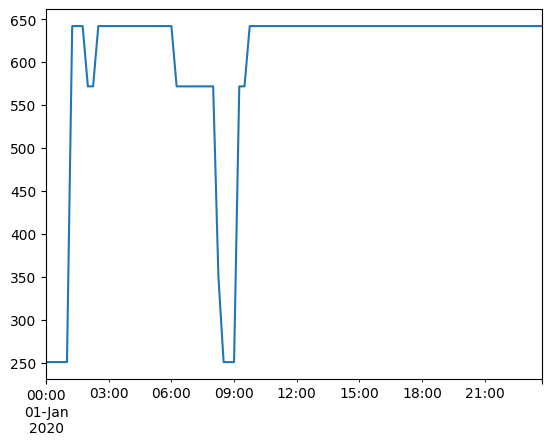

In [116]:
res_df.data_source.loc['air_water_heat_pump'].df.q_cond_kw.plot()
plt.show()

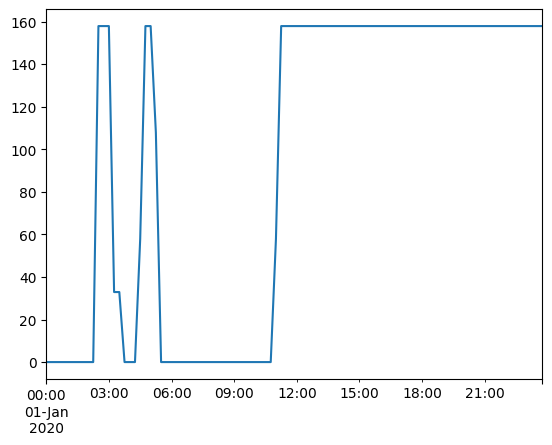

In [117]:
res_df.data_source.loc['heat_consumer'].df.q_uncovered_kw.plot()
plt.show()

In the previous graph, we can observe that when the heat demand is lower than the heat pump’s capacity, the excess supply is redirected to the dry cooler.

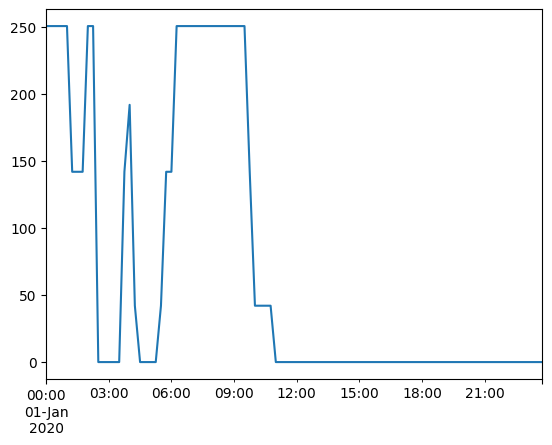

In [118]:
res_df.data_source.loc['dry cooler'].df.q_exchanged_kw.plot()
plt.show()